🧠 Hyperparameter Tuning for MLP
Date: May 21, 2025

🎯 Goal
Identify the optimal configuration of hyperparameters for a Multi-Layer Perceptron (MLP) model, including:

hidden_dim: number of hidden units

learning_rate: optimizer step size

batch_size: number of samples per training step

activation_fn: activation function

optimizer: optimization algorithm

⚙️ General Settings
epochs = 100

output_dim = 1

n_runs = 30 (random seeds for reproducibility)

📌 Tuned Parameters
Hidden Dimensions: [64, 128]

Learning Rate: [0.007, 0.008, 0.009, 0.01]

Batch Size: [16, 32, 64]

Activation Functions: [nn.Tanh]
(can be extended to [nn.ReLU, nn.LeakyReLU, nn.Tanh])

Optimizers: ["Adam"]
(optionally expandable to ["Adam", "AdamW", "SGD", "RMSprop"])

📊 Training Procedure
Each configuration is trained using 5-fold cross-validation

Early stopping is applied with patience = 100

Metrics are calculated on each fold and averaged:

R² (coefficient of determination)

MAE (mean absolute error)

MSE (mean squared error)

💾 Outputs Saved
Model weights

Configuration files

Evaluation metrics per run

Global experiment log (experiments_log.csv)

Training visualizations (loss_plot.png)

🏁 Final Results
Table of stable configurations (R² ≥ 95% of the best score)

Visual analysis of hyperparameter impact (boxplots per parameter)

Best configuration is highlighted separately

In [1]:
# 📦 Imports and Configuration

import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import TensorDataset, DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm




In [2]:
# ➤ Paths for hyperparameter search: tuning runs, logs, results

# ----------------------------
# Device setup
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🛠 Device: {device}")

DATA_PATH = "/kaggle/input/windloading-train/WindLoading_Train.csv"
SAVE_ROOT = "/kaggle/working"

# DATA_PATH = "/mnt/d/projects/wind_fluctuation_prediction_2025/data/processed/windloading_train.csv"
# SAVE_ROOT = "/mnt/d/projects/wind_fluctuation_prediction_2025/experiments"

TUNING_DIR = os.path.join(SAVE_ROOT, "tuning_mlp")
LOG_CSV_PATH = os.path.join(SAVE_ROOT, "experiments_log.csv")

os.makedirs(TUNING_DIR, exist_ok=True)

# ➤ Function to create a run-specific directory
def create_run_directory(hidden_dim, lr, batch_size=64, epochs=500, activation_fn=None, optimizer_name=None, base_dir=TUNING_DIR):
    run_id = f"mlp_{hidden_dim}h_{lr:.0e}lr_{batch_size}bs_{epochs}ep"

    # 👇 Добавим активацию в имя, если она передана
    if activation_fn is not None:
        run_id += f"_{activation_fn.__name__}"

    # 👇 Добавим имя оптимизатора в имя, если оно передано
    if optimizer_name is not None:
        run_id += f"_{optimizer_name}"

    run_dir = os.path.join(base_dir, run_id)
    os.makedirs(run_dir, exist_ok=True)
    print(f"📂 Created run directory: {run_dir}")
    return run_id, run_dir

🛠 Device: cuda


In [3]:
# ➤ Function for loading the dataset from CSV

def load_dataset():
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    return df

In [4]:
# ➞ Function to compute regression metrics: MSE, MAE, R²

def evaluate_regression(y_true, y_pred):
    y_true_np = y_true.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()

    # 🔍 Remove NaNs before computing metrics
    mask = ~np.isnan(y_true_np) & ~np.isnan(y_pred_np)
    y_true_np = y_true_np[mask]
    y_pred_np = y_pred_np[mask]

    if len(y_true_np) == 0 or len(y_pred_np) == 0:
        raise ValueError("No valid data points after removing NaNs.")

    mse = mean_squared_error(y_true_np, y_pred_np)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    r2 = r2_score(y_true_np, y_pred_np)

    return {"MSE": mse, "MAE": mae, "R2": r2}


In [5]:
# ➤ Definition of the MLP architecture with customizable activation function

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation_fn):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)


In [6]:
# ➤ Training function for MLP model: used in Random Search and experiment tracking

def train_mlp(hidden_dim, lr, batch_size, epochs, output_dim=1, activation_fn=nn.ReLU, optimizer_name="Adam"):

    # ----------------------------
    # Ensure CSV file exists and has header
    # ----------------------------
    if not os.path.exists(LOG_CSV_PATH):
        with open(LOG_CSV_PATH, "w") as f:
            f.write("run_id,hidden_dim,lr,batch_size,activation_fn,optimizer_name,R2,MAE,MSE\n")


    # ----------------------------
    # Load dataset
    # ----------------------------
    df = load_dataset()
    X = df[['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang']]
    y = df[['StdDev']]
    input_dim = X.shape[1]

    # 🔍 Проверка первых строк X и y
    print("📄 Features (X):")
    print("\n🎯 Target (y):")
    # display(y.head())

    # 📐 Размерности
    print(f"\n✅ X shape: {X.shape}")
    print(f"✅ y shape: {y.shape}")


    # ----------------------------
    # K-Fold Cross-Validation
    # ----------------------------
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\n🔁 Fold {fold + 1} / 5")

        # 📊 Разделение данных
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # 🔁 Преобразуем в тензоры
        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
        X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to(device)

        batch_X = X_train_tensor
        batch_y = y_train_tensor
        
        '''
        # 📦 DataLoader с правильным порядком
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        '''
        print("X_train.shape =", X_train.shape)


        # 🧠 Создание новой модели на каждый фолд
        model = MLP(input_dim, hidden_dim, output_dim, activation_fn=activation_fn).to(device)
        print("📦 Model is on device:", next(model.parameters()).device)

         # ----------------------------
        # Training loop
        # ----------------------------
        criterion = nn.MSELoss()
        if optimizer_name == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif optimizer_name == "SGD":
            optimizer = optim.SGD(model.parameters(), lr=lr)
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(model.parameters(), lr=lr)
        elif optimizer_name == "AdamW":
            optimizer = optim.AdamW(model.parameters(), lr=lr)
        else:
            raise ValueError(f"Unknown optimizer: {optimizer_name}")
        train_loss_history = []

        # 🔁 Early Stopping init
        early_stopping_patience = 100
        patience_counter = 0
        best_loss = float('inf') 

        for epoch in tqdm(range(epochs), desc="Epochs"):
            model.train()
            epoch_loss = 0.0

            accumulation_steps = 1  # 🧠 Обновляем веса каждые 1000 батчей
            optimizer.zero_grad()
            epoch_loss = 0.0
                        
            '''
            for batch_idx, (batch_X, batch_y) in enumerate(train_loader):
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss = loss / accumulation_steps  # 🔁 делим loss, чтобы избежать взрыва градиентов
                loss.backward()
                epoch_loss += loss.item() * accumulation_steps
            
                if (batch_idx + 1) % accumulation_steps != 0:
                    optimizer.step()
                    optimizer.zero_grad()
            '''
            outputs = model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()

            '''
            current_loss = epoch_loss / len(train_loader)
            '''
            current_loss = loss.item()
            train_loss_history.append(current_loss)

            # 💡 Early Stopping check (выполняется на каждой эпохе)
            if current_loss < best_loss:
                best_loss = current_loss
                patience_counter = 0
            else:
                patience_counter += 1
                
                if patience_counter >= early_stopping_patience:
                    print(f"⏹️ Early stopping at epoch {epoch+1} — no improvement in {early_stopping_patience} epochs.")
                    break

            # ⏺️ Logging (только раз в 10 эпох)
            if (epoch + 1) % 3000 == 0:
                log_str = f"Epoch [{epoch+1}/{epochs}], Loss: {current_loss:.4f}"
                print(log_str)

        model.eval()
        with torch.no_grad():
            y_pred = model(X_val_tensor)
            metrics = evaluate_regression(y_val_tensor, y_pred)
            fold_metrics.append(metrics)
            print(f"📈 Fold {fold + 1} metrics: {metrics}")

    # ----------------------------
    # Average metrics across folds
    # ----------------------------
    avg_metrics = {
        "MSE": sum(m["MSE"] for m in fold_metrics) / len(fold_metrics),
        "MAE": sum(m["MAE"] for m in fold_metrics) / len(fold_metrics),
        "R2":  sum(m["R2"]  for m in fold_metrics) / len(fold_metrics),
    }
    
    # ----------------------------
    # Run directory
    # ----------------------------
    run_id, run_dir = create_run_directory(
        hidden_dim=hidden_dim,
        lr=lr,
        batch_size=batch_size,
        epochs=epochs,
        activation_fn=activation_fn,
        optimizer_name=optimizer_name
    )

    # ----------------------------
    # Save config
    # ----------------------------
    config = {
        "input_dim": input_dim,
        "hidden_dim": hidden_dim,
        "output_dim": output_dim,
        "lr": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "activation_fn": activation_fn.__name__,
        "optimizer_name": optimizer_name,
        "features": ['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang'],
        "targets": ['StdDev']
    }
    config_filename = f"config_{run_id}_ex.json"
    with open(os.path.join(run_dir, config_filename), "w") as f:
        json.dump(config, f, indent=4)

    # ----------------------------
    # Append summary to global CSV log
    # ----------------------------
    with open(LOG_CSV_PATH, "a") as f:
        f.write(f"{run_id},{hidden_dim},{lr:.0e},{batch_size},{activation_fn.__name__},{optimizer_name},{avg_metrics['R2']:.4f},{avg_metrics['MAE']:.4f},{avg_metrics['MSE']:.6f}\n")

    print(f"\n📊 Average metrics across 5 folds:\n{avg_metrics}")
    return run_id, avg_metrics
    



In [7]:
# 📁 src/tuning/random_search_mlp.py
# ➤ Random Search for MLP model: selects hyperparameters and launches training

# 🔧 Hyperparameter options
# hidden_dim_choices = [128]
# hidden_dim_choices = [32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 384]
hidden_dim_choices = [256]

# lr_choices = [0.009]
# lr_choices = [round(lr, 5) for lr in np.arange(0.001, 0.021, 0.001)]
lr_choices = [round(lr, 5) for lr in np.arange(0.003, 0.005, 0.001)]

# batch_size_choices = [64]
# batch_size_choices = [8, 16, 32, 48, 64, 96, 128]
batch_size_choices = [32]


activation_choices = [nn.Tanh]
# activation_choices = [nn.ReLU, nn.LeakyReLU, nn.Tanh]
optimizer_choices = ["Adam"]
# optimizer_choices = ["Adam", "AdamW"]

# 📌 Fixed parameters
EPOCHS = 10000
OUTPUT_DIM = 1
N_RUNS = 30 # Total number of runs

# 🧪 Random Search loop
for run in range(N_RUNS):
    # Randomly select hyperparameters
    hidden_dim = random.choice(hidden_dim_choices)
    lr = random.choice(lr_choices)
    batch_size = random.choice(batch_size_choices)
    activation_fn=random.choice(activation_choices)
    optimizer_name = random.choice(optimizer_choices)

    # Display current configuration
    print(f"\n🔁 Run {run + 1}/{N_RUNS}")
    print(f"→ hidden_dim: {hidden_dim}, lr: {lr:.5f}, batch size: {batch_size}, activation_fn: {activation_fn.__name__}, optimizer_name: {optimizer_name}")

    # Train model with current hyperparameters
    train_mlp(
        hidden_dim=hidden_dim,
        lr=lr,
        batch_size=batch_size,
        epochs=EPOCHS,
        output_dim=OUTPUT_DIM,
        activation_fn=activation_fn,
        optimizer_name=optimizer_name
    )


🔁 Run 1/30
→ hidden_dim: 256, lr: 0.00400, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3010/10000 [00:51<02:04, 56.07it/s]

Epoch [3000/10000], Loss: 0.0037


Epochs:  39%|███▉      | 3906/10000 [01:08<01:46, 57.44it/s]


⏹️ Early stopping at epoch 3907 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0029939208, 'MAE': 0.03978104, 'R2': 0.5708379083355901}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3005/10000 [00:59<02:12, 52.89it/s]

Epoch [3000/10000], Loss: 0.0034


Epochs:  36%|███▋      | 3640/10000 [01:11<02:05, 50.83it/s]


⏹️ Early stopping at epoch 3641 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.002625, 'MAE': 0.036213942, 'R2': 0.6225021425303487}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:58<02:21, 49.39it/s]

Epoch [3000/10000], Loss: 0.0039


Epochs:  60%|██████    | 6005/10000 [01:58<01:16, 51.93it/s]

Epoch [6000/10000], Loss: 0.0023


Epochs:  65%|██████▌   | 6516/10000 [02:08<01:08, 50.73it/s]


⏹️ Early stopping at epoch 6517 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0017399188, 'MAE': 0.0287651, 'R2': 0.7519304811593829}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:13, 52.35it/s]

Epoch [3000/10000], Loss: 0.0033


Epochs:  60%|██████    | 6006/10000 [01:54<01:15, 52.58it/s]

Epoch [6000/10000], Loss: 0.0015


Epochs:  62%|██████▏   | 6173/10000 [01:57<01:12, 52.50it/s]


⏹️ Early stopping at epoch 6174 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.001386377, 'MAE': 0.026085645, 'R2': 0.796263198640504}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:56<02:10, 53.55it/s]

Epoch [3000/10000], Loss: 0.0029


Epochs:  59%|█████▊    | 5860/10000 [01:50<01:17, 53.11it/s]


⏹️ Early stopping at epoch 5861 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0019407227, 'MAE': 0.030531112, 'R2': 0.7172388123450149}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_4e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0021371878683567047, 'MAE': 0.03227536790072918, 'R2': 0.6917545086021681}

🔁 Run 2/30
→ hidden_dim: 256, lr: 0.00400, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3005/10000 [00:58<02:19, 50.19it/s]

Epoch [3000/10000], Loss: 0.0033


Epochs:  60%|██████    | 6006/10000 [01:58<01:20, 49.55it/s]

Epoch [6000/10000], Loss: 0.0045


Epochs:  63%|██████▎   | 6284/10000 [02:03<01:13, 50.73it/s]


⏹️ Early stopping at epoch 6285 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0016406061, 'MAE': 0.028211283, 'R2': 0.7648280956884821}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:56<02:12, 52.91it/s]

Epoch [3000/10000], Loss: 0.0042


Epochs:  40%|███▉      | 3969/10000 [01:15<01:54, 52.77it/s]


⏹️ Early stopping at epoch 3970 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.003143191, 'MAE': 0.043826483, 'R2': 0.5479817016600983}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:59<02:18, 50.62it/s]

Epoch [3000/10000], Loss: 0.0036


Epochs:  60%|██████    | 6008/10000 [01:58<01:20, 49.55it/s]

Epoch [6000/10000], Loss: 0.0019


Epochs:  90%|█████████ | 9007/10000 [02:58<00:20, 49.58it/s]

Epoch [9000/10000], Loss: 0.0012


Epochs:  95%|█████████▍| 9494/10000 [03:08<00:10, 50.31it/s]


⏹️ Early stopping at epoch 9495 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0055049798, 'MAE': 0.05875375, 'R2': 0.21512557904197216}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:15, 51.57it/s]

Epoch [3000/10000], Loss: 0.0032


Epochs:  33%|███▎      | 3329/10000 [01:04<02:09, 51.44it/s]


⏹️ Early stopping at epoch 3330 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0032179148, 'MAE': 0.04111905, 'R2': 0.5271072402710657}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [01:00<02:20, 49.65it/s]

Epoch [3000/10000], Loss: 0.0042


Epochs:  35%|███▌      | 3528/10000 [01:10<02:09, 50.05it/s]


⏹️ Early stopping at epoch 3529 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0029825075, 'MAE': 0.04098678, 'R2': 0.5654519025290774}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_4e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0032978398492559792, 'MAE': 0.04257946945726872, 'R2': 0.5240989038381392}

🔁 Run 3/30
→ hidden_dim: 256, lr: 0.00400, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3007/10000 [00:59<02:21, 49.55it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  49%|████▉     | 4910/10000 [01:38<01:41, 50.09it/s]


⏹️ Early stopping at epoch 4911 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0027662122, 'MAE': 0.04263385, 'R2': 0.6034786390169624}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:15, 51.64it/s]

Epoch [3000/10000], Loss: 0.0024


Epochs:  60%|██████    | 6006/10000 [01:55<01:16, 52.49it/s]

Epoch [6000/10000], Loss: 0.0019


Epochs:  69%|██████▊   | 6863/10000 [02:11<01:00, 52.19it/s]


⏹️ Early stopping at epoch 6864 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0015334538, 'MAE': 0.026408501, 'R2': 0.7794759776364839}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3009/10000 [00:58<02:15, 51.76it/s]

Epoch [3000/10000], Loss: 0.0032


Epochs:  40%|████      | 4028/10000 [01:18<01:56, 51.23it/s]


⏹️ Early stopping at epoch 4029 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.002938674, 'MAE': 0.04249743, 'R2': 0.5810175306894183}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:14, 51.86it/s]

Epoch [3000/10000], Loss: 0.0036


Epochs:  45%|████▌     | 4528/10000 [01:27<01:45, 51.94it/s]


⏹️ Early stopping at epoch 4529 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0017610849, 'MAE': 0.029468518, 'R2': 0.7411975387632384}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:16, 51.40it/s]

Epoch [3000/10000], Loss: 0.0036


Epochs:  55%|█████▍    | 5488/10000 [01:47<01:28, 51.26it/s]


⏹️ Early stopping at epoch 5489 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.002115037, 'MAE': 0.033954136, 'R2': 0.6918413959351561}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_4e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0022228924091905354, 'MAE': 0.03499248698353767, 'R2': 0.6794022164082518}

🔁 Run 4/30
→ hidden_dim: 256, lr: 0.00400, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:59<02:20, 49.77it/s]

Epoch [3000/10000], Loss: 0.0027


Epochs:  60%|██████    | 6008/10000 [01:59<01:19, 50.33it/s]

Epoch [6000/10000], Loss: 0.0017


Epochs:  77%|███████▋  | 7705/10000 [02:33<00:45, 50.17it/s]


⏹️ Early stopping at epoch 7706 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0014443484, 'MAE': 0.026522888, 'R2': 0.7929605811942011}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:13, 52.49it/s]

Epoch [3000/10000], Loss: 0.0026


Epochs:  40%|███▉      | 3963/10000 [01:15<01:54, 52.62it/s]


⏹️ Early stopping at epoch 3964 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0064371326, 'MAE': 0.0710756, 'R2': 0.07428420073838471}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:19, 50.25it/s]

Epoch [3000/10000], Loss: 0.0045


Epochs:  45%|████▌     | 4513/10000 [01:28<01:47, 51.16it/s]


⏹️ Early stopping at epoch 4514 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0038333014, 'MAE': 0.042931832, 'R2': 0.4534657423601891}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:59<02:19, 50.00it/s]

Epoch [3000/10000], Loss: 0.0029


Epochs:  46%|████▌     | 4585/10000 [01:31<01:47, 50.34it/s]


⏹️ Early stopping at epoch 4586 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0023541308, 'MAE': 0.032614496, 'R2': 0.6540457225766687}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:12, 52.67it/s]

Epoch [3000/10000], Loss: 0.0036


Epochs:  60%|██████    | 6006/10000 [01:54<01:16, 52.25it/s]

Epoch [6000/10000], Loss: 0.0021


Epochs:  67%|██████▋   | 6667/10000 [02:07<01:03, 52.48it/s]


⏹️ Early stopping at epoch 6668 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.002164989, 'MAE': 0.035656713, 'R2': 0.6845634731131257}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_4e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.003246780438348651, 'MAE': 0.04176030643284321, 'R2': 0.5318639439965139}

🔁 Run 5/30
→ hidden_dim: 256, lr: 0.00400, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:59<02:15, 51.78it/s]

Epoch [3000/10000], Loss: 0.0031


Epochs:  51%|█████▏    | 5133/10000 [01:41<01:36, 50.60it/s]


⏹️ Early stopping at epoch 5134 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0026069027, 'MAE': 0.03924201, 'R2': 0.6263147651656619}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:14, 51.99it/s]

Epoch [3000/10000], Loss: 0.0050


Epochs:  60%|██████    | 6007/10000 [01:58<01:20, 49.59it/s]

Epoch [6000/10000], Loss: 0.0020


Epochs:  79%|███████▉  | 7942/10000 [02:37<00:40, 50.58it/s]


⏹️ Early stopping at epoch 7943 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0014286721, 'MAE': 0.028178394, 'R2': 0.7945445075407549}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3010/10000 [00:58<02:16, 51.28it/s]

Epoch [3000/10000], Loss: 0.0027


Epochs:  46%|████▌     | 4551/10000 [01:28<01:46, 51.18it/s]


⏹️ Early stopping at epoch 4552 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0023598424, 'MAE': 0.03351548, 'R2': 0.6635446796281657}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:13, 52.26it/s]

Epoch [3000/10000], Loss: 0.0028


Epochs:  34%|███▍      | 3403/10000 [01:04<02:05, 52.41it/s]


⏹️ Early stopping at epoch 3404 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.002834594, 'MAE': 0.037383985, 'R2': 0.5834385847844739}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:13, 52.28it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  36%|███▋      | 3632/10000 [01:09<02:01, 52.56it/s]


⏹️ Early stopping at epoch 3633 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0030053363, 'MAE': 0.04421478, 'R2': 0.5621257674497835}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_4e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.002447069529443979, 'MAE': 0.03650692999362946, 'R2': 0.645993660913768}

🔁 Run 6/30
→ hidden_dim: 256, lr: 0.00400, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3005/10000 [00:58<02:16, 51.14it/s]

Epoch [3000/10000], Loss: 0.0024


Epochs:  59%|█████▉    | 5936/10000 [01:56<01:19, 51.09it/s]


⏹️ Early stopping at epoch 5937 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0016593441, 'MAE': 0.027968379, 'R2': 0.7621421424710034}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:56<02:12, 52.78it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  60%|██████    | 6006/10000 [01:54<01:16, 52.41it/s]

Epoch [6000/10000], Loss: 0.0020


Epochs:  69%|██████▉   | 6889/10000 [02:11<00:59, 52.57it/s]


⏹️ Early stopping at epoch 6890 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0018579467, 'MAE': 0.029338477, 'R2': 0.7328110916446875}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3010/10000 [00:58<02:14, 51.90it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  57%|█████▋    | 5682/10000 [01:50<01:24, 51.20it/s]


⏹️ Early stopping at epoch 5683 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0019755808, 'MAE': 0.030611942, 'R2': 0.7183308777655086}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  24%|██▍       | 2421/10000 [00:46<02:26, 51.88it/s]


⏹️ Early stopping at epoch 2422 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0032551216, 'MAE': 0.042049725, 'R2': 0.5216394501628336}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:17, 51.01it/s]

Epoch [3000/10000], Loss: 0.0032


Epochs:  56%|█████▌    | 5582/10000 [01:49<01:26, 50.97it/s]


⏹️ Early stopping at epoch 5583 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0018254917, 'MAE': 0.030833315, 'R2': 0.7340278367188979}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_4e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0021146969869732858, 'MAE': 0.0321603674441576, 'R2': 0.6937902797525862}

🔁 Run 7/30
→ hidden_dim: 256, lr: 0.00300, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3010/10000 [00:58<02:19, 50.22it/s]

Epoch [3000/10000], Loss: 0.0028


Epochs:  60%|██████    | 6008/10000 [01:58<01:20, 49.81it/s]

Epoch [6000/10000], Loss: 0.0020


Epochs:  74%|███████▍  | 7375/10000 [02:26<00:52, 50.38it/s]


⏹️ Early stopping at epoch 7376 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0020964944, 'MAE': 0.031975497, 'R2': 0.6994790235785177}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:56<02:12, 52.65it/s]

Epoch [3000/10000], Loss: 0.0031


Epochs:  60%|██████    | 6006/10000 [01:54<01:16, 52.24it/s]

Epoch [6000/10000], Loss: 0.0018


Epochs:  64%|██████▎   | 6363/10000 [02:01<01:09, 52.41it/s]


⏹️ Early stopping at epoch 6364 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.001817287, 'MAE': 0.030499358, 'R2': 0.738658294365387}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3010/10000 [00:58<02:16, 51.15it/s]

Epoch [3000/10000], Loss: 0.0024


Epochs:  60%|██████    | 6010/10000 [01:57<01:16, 52.26it/s]

Epoch [6000/10000], Loss: 0.0018


Epochs:  66%|██████▌   | 6615/10000 [02:09<01:06, 51.22it/s]


⏹️ Early stopping at epoch 6616 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0017804749, 'MAE': 0.030411895, 'R2': 0.7461481752668113}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  27%|██▋       | 2699/10000 [00:52<02:21, 51.56it/s]


⏹️ Early stopping at epoch 2700 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0031415285, 'MAE': 0.04074802, 'R2': 0.5383327440802567}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:17, 50.97it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  60%|██████    | 6008/10000 [01:58<01:20, 49.64it/s]

Epoch [6000/10000], Loss: 0.0021


Epochs:  78%|███████▊  | 7814/10000 [02:34<00:43, 50.57it/s]


⏹️ Early stopping at epoch 7815 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0017369037, 'MAE': 0.030379768, 'R2': 0.7469350296419595}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_3e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0021145376842468975, 'MAE': 0.03280290737748146, 'R2': 0.6939106533865864}

🔁 Run 8/30
→ hidden_dim: 256, lr: 0.00300, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:58<02:20, 49.62it/s]

Epoch [3000/10000], Loss: 0.0027


Epochs:  60%|██████    | 6006/10000 [01:59<01:20, 49.66it/s]

Epoch [6000/10000], Loss: 0.0018


Epochs:  75%|███████▍  | 7463/10000 [02:28<00:50, 50.30it/s]


⏹️ Early stopping at epoch 7464 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0017583019, 'MAE': 0.028309455, 'R2': 0.7479570469855595}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:12, 52.67it/s]

Epoch [3000/10000], Loss: 0.0024


Epochs:  60%|██████    | 6006/10000 [01:54<01:16, 52.20it/s]

Epoch [6000/10000], Loss: 0.0017


Epochs:  71%|███████   | 7088/10000 [02:15<00:55, 52.43it/s]


⏹️ Early stopping at epoch 7089 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.002382103, 'MAE': 0.039846938, 'R2': 0.6574328438870034}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3005/10000 [00:58<02:16, 51.36it/s]

Epoch [3000/10000], Loss: 0.0043


Epochs:  59%|█████▉    | 5902/10000 [01:55<01:19, 51.26it/s]


⏹️ Early stopping at epoch 5903 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.002348194, 'MAE': 0.033033624, 'R2': 0.6652054449655578}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:17, 50.84it/s]

Epoch [3000/10000], Loss: 0.0024


Epochs:  60%|██████    | 6006/10000 [01:57<01:20, 49.56it/s]

Epoch [6000/10000], Loss: 0.0017


Epochs:  75%|███████▌  | 7538/10000 [02:27<00:48, 50.95it/s]


⏹️ Early stopping at epoch 7539 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0017688214, 'MAE': 0.031863898, 'R2': 0.7400606185878413}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:56<02:12, 52.71it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  60%|██████    | 6006/10000 [01:53<01:16, 52.08it/s]

Epoch [6000/10000], Loss: 0.0019


Epochs:  67%|██████▋   | 6673/10000 [02:06<01:03, 52.70it/s]


⏹️ Early stopping at epoch 6674 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.001949629, 'MAE': 0.03371185, 'R2': 0.7159411613536675}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_3e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.002041409816592932, 'MAE': 0.03335315324366093, 'R2': 0.7053194231559259}

🔁 Run 9/30
→ hidden_dim: 256, lr: 0.00300, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3005/10000 [00:59<02:17, 50.89it/s]

Epoch [3000/10000], Loss: 0.0041


Epochs:  55%|█████▍    | 5491/10000 [01:48<01:29, 50.38it/s]


⏹️ Early stopping at epoch 5492 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.003294285, 'MAE': 0.045423854, 'R2': 0.5277823148941402}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:56<02:12, 52.61it/s]

Epoch [3000/10000], Loss: 0.0032


Epochs:  60%|██████    | 6006/10000 [01:54<01:16, 52.39it/s]

Epoch [6000/10000], Loss: 0.0022


Epochs:  68%|██████▊   | 6754/10000 [02:08<01:01, 52.55it/s]


⏹️ Early stopping at epoch 6755 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.004051239, 'MAE': 0.052232463, 'R2': 0.4173965319585835}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:16, 51.13it/s]

Epoch [3000/10000], Loss: 0.0029


Epochs:  50%|█████     | 5014/10000 [01:37<01:37, 51.35it/s]


⏹️ Early stopping at epoch 5015 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0023879851, 'MAE': 0.035308853, 'R2': 0.6595321816412998}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:13, 52.33it/s]

Epoch [3000/10000], Loss: 0.0032


Epochs:  60%|██████    | 6006/10000 [01:55<01:18, 51.09it/s]

Epoch [6000/10000], Loss: 0.0021


Epochs:  84%|████████▍ | 8449/10000 [02:42<00:29, 52.00it/s]


⏹️ Early stopping at epoch 8450 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0015046697, 'MAE': 0.027267868, 'R2': 0.7788793480802556}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:56<02:12, 52.84it/s]

Epoch [3000/10000], Loss: 0.0028


Epochs:  60%|██████    | 6006/10000 [01:54<01:16, 52.02it/s]

Epoch [6000/10000], Loss: 0.0018


Epochs:  78%|███████▊  | 7755/10000 [02:27<00:42, 52.55it/s]


⏹️ Early stopping at epoch 7756 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0015373981, 'MAE': 0.02724764, 'R2': 0.7760027694482863}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_3e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.00255511540453881, 'MAE': 0.03749613538384437, 'R2': 0.6319186292045131}

🔁 Run 10/30
→ hidden_dim: 256, lr: 0.00300, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:58<02:17, 50.98it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  40%|████      | 4032/10000 [01:18<01:56, 51.41it/s]


⏹️ Early stopping at epoch 4033 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0023178663, 'MAE': 0.03407919, 'R2': 0.6677465614312189}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:14, 52.19it/s]

Epoch [3000/10000], Loss: 0.0053


Epochs:  60%|██████    | 6006/10000 [01:55<01:18, 51.15it/s]

Epoch [6000/10000], Loss: 0.0025


Epochs:  71%|███████▏  | 7127/10000 [02:17<00:55, 51.78it/s]


⏹️ Early stopping at epoch 7128 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0021316814, 'MAE': 0.03238245, 'R2': 0.6934456380029054}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3010/10000 [00:58<02:15, 51.77it/s]

Epoch [3000/10000], Loss: 0.0063


Epochs:  60%|██████    | 6009/10000 [01:58<01:20, 49.72it/s]

Epoch [6000/10000], Loss: 0.0024


Epochs:  69%|██████▉   | 6944/10000 [02:16<01:00, 50.71it/s]


⏹️ Early stopping at epoch 6945 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0024242743, 'MAE': 0.035644647, 'R2': 0.6543582524865856}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:14, 52.08it/s]

Epoch [3000/10000], Loss: 0.0028


Epochs:  43%|████▎     | 4269/10000 [01:23<01:51, 51.32it/s]


⏹️ Early stopping at epoch 4270 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0022331104, 'MAE': 0.03352873, 'R2': 0.6718304480724557}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3004/10000 [00:59<02:19, 50.10it/s]

Epoch [3000/10000], Loss: 0.0029


Epochs:  58%|█████▊    | 5828/10000 [01:55<01:22, 50.57it/s]


⏹️ Early stopping at epoch 5829 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.002068549, 'MAE': 0.031094935, 'R2': 0.6986146581904709}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_3e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.002235096273943782, 'MAE': 0.03334599062800407, 'R2': 0.6771991116367273}

🔁 Run 11/30
→ hidden_dim: 256, lr: 0.00300, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3009/10000 [00:59<02:19, 49.95it/s]

Epoch [3000/10000], Loss: 0.0040


Epochs:  60%|██████    | 6008/10000 [01:59<01:18, 50.55it/s]

Epoch [6000/10000], Loss: 0.0023


Epochs:  61%|██████    | 6057/10000 [02:00<01:18, 50.47it/s]


⏹️ Early stopping at epoch 6058 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0023157531, 'MAE': 0.034626085, 'R2': 0.6680494696817043}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3009/10000 [00:58<02:19, 50.18it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  60%|██████    | 6009/10000 [01:58<01:19, 49.95it/s]

Epoch [6000/10000], Loss: 0.0026


Epochs:  61%|██████▏   | 6144/10000 [02:01<01:16, 50.64it/s]


⏹️ Early stopping at epoch 6145 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0025064081, 'MAE': 0.037104685, 'R2': 0.6395566853719306}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3007/10000 [00:59<02:19, 50.27it/s]

Epoch [3000/10000], Loss: 0.0023


Epochs:  60%|██████    | 6005/10000 [01:59<01:18, 50.76it/s]

Epoch [6000/10000], Loss: 0.0017


Epochs:  90%|█████████ | 9007/10000 [02:59<00:20, 49.60it/s]

Epoch [9000/10000], Loss: 0.0028


Epochs:  99%|█████████▉| 9888/10000 [03:17<00:02, 50.07it/s]


⏹️ Early stopping at epoch 9889 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0037337972, 'MAE': 0.04332942, 'R2': 0.4676525552610644}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:12, 52.91it/s]

Epoch [3000/10000], Loss: 0.0029


Epochs:  60%|██████    | 6006/10000 [01:54<01:16, 52.25it/s]

Epoch [6000/10000], Loss: 0.0017


Epochs:  66%|██████▌   | 6623/10000 [02:06<01:04, 52.39it/s]


⏹️ Early stopping at epoch 6624 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0026935323, 'MAE': 0.042810738, 'R2': 0.604168539444419}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:13, 52.28it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  60%|██████    | 6006/10000 [01:54<01:15, 52.67it/s]

Epoch [6000/10000], Loss: 0.0025


Epochs:  60%|██████    | 6019/10000 [01:54<01:15, 52.54it/s]


⏹️ Early stopping at epoch 6020 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0019452755, 'MAE': 0.030529622, 'R2': 0.7165754948509044}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_3e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0026389532489702106, 'MAE': 0.037680110335350035, 'R2': 0.6192005489220045}

🔁 Run 12/30
→ hidden_dim: 256, lr: 0.00400, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:16, 51.08it/s]

Epoch [3000/10000], Loss: 0.0032


Epochs:  60%|██████    | 6005/10000 [01:56<01:16, 52.08it/s]

Epoch [6000/10000], Loss: 0.0020


Epochs:  70%|███████   | 7023/10000 [02:16<00:58, 51.28it/s]


⏹️ Early stopping at epoch 7024 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0018337958, 'MAE': 0.029018464, 'R2': 0.737135448642305}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:16, 51.12it/s]

Epoch [3000/10000], Loss: 0.0027


Epochs:  36%|███▌      | 3579/10000 [01:09<02:04, 51.66it/s]


⏹️ Early stopping at epoch 3580 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0036135686, 'MAE': 0.04397803, 'R2': 0.4803373474370507}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3005/10000 [00:58<02:18, 50.48it/s]

Epoch [3000/10000], Loss: 0.0021


Epochs:  44%|████▍     | 4415/10000 [01:26<01:49, 51.21it/s]


⏹️ Early stopping at epoch 4416 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0030777869, 'MAE': 0.045768928, 'R2': 0.5611834866071657}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:56<02:12, 52.85it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  35%|███▍      | 3452/10000 [01:05<02:03, 52.99it/s]


⏹️ Early stopping at epoch 3453 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.003009898, 'MAE': 0.038510267, 'R2': 0.5576765920608389}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:14, 51.81it/s]

Epoch [3000/10000], Loss: 0.0029


Epochs:  41%|████      | 4100/10000 [01:19<01:53, 51.81it/s]


⏹️ Early stopping at epoch 4101 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0023917167, 'MAE': 0.03674257, 'R2': 0.651529462703661}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_4e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0027853531762957575, 'MAE': 0.0388036523014307, 'R2': 0.5975724674902043}

🔁 Run 13/30
→ hidden_dim: 256, lr: 0.00300, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:15, 51.52it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  60%|██████    | 6006/10000 [01:56<01:17, 51.47it/s]

Epoch [6000/10000], Loss: 0.0023


Epochs:  66%|██████▌   | 6616/10000 [02:07<01:05, 51.69it/s]


⏹️ Early stopping at epoch 6617 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0018939, 'MAE': 0.02966817, 'R2': 0.7285198502168084}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:56<02:12, 52.71it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  60%|██████    | 6006/10000 [01:53<01:15, 52.76it/s]

Epoch [6000/10000], Loss: 0.0015


Epochs:  70%|███████   | 7048/10000 [02:13<00:55, 52.84it/s]


⏹️ Early stopping at epoch 7049 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0014292971, 'MAE': 0.025977477, 'R2': 0.794454609241462}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:13, 52.37it/s]

Epoch [3000/10000], Loss: 0.0035


Epochs:  41%|████      | 4088/10000 [01:19<01:54, 51.41it/s]


⏹️ Early stopping at epoch 4089 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0027729159, 'MAE': 0.041445896, 'R2': 0.6046505745506116}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:14, 52.04it/s]

Epoch [3000/10000], Loss: 0.0038


Epochs:  55%|█████▍    | 5498/10000 [01:45<01:26, 52.23it/s]


⏹️ Early stopping at epoch 5499 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0017603124, 'MAE': 0.031733964, 'R2': 0.7413110546069007}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:56<02:12, 52.86it/s]

Epoch [3000/10000], Loss: 0.0027


Epochs:  60%|██████    | 6006/10000 [01:53<01:15, 52.73it/s]

Epoch [6000/10000], Loss: 0.0020


Epochs:  73%|███████▎  | 7265/10000 [02:17<00:51, 52.89it/s]


⏹️ Early stopping at epoch 7266 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0015983908, 'MAE': 0.029407555, 'R2': 0.7671162012344986}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_3e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0018909632228314877, 'MAE': 0.03164661228656769, 'R2': 0.7272104579700562}

🔁 Run 14/30
→ hidden_dim: 256, lr: 0.00400, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:58<02:17, 50.96it/s]

Epoch [3000/10000], Loss: 0.0035


Epochs:  44%|████▍     | 4437/10000 [01:27<01:49, 50.94it/s]


⏹️ Early stopping at epoch 4438 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0022714327, 'MAE': 0.033099424, 'R2': 0.6744026025147635}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3004/10000 [00:58<02:17, 50.80it/s]

Epoch [3000/10000], Loss: 0.0031


Epochs:  39%|███▉      | 3943/10000 [01:17<01:58, 50.91it/s]


⏹️ Early stopping at epoch 3944 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0020354425, 'MAE': 0.033399913, 'R2': 0.707285629856738}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3007/10000 [00:59<02:17, 50.99it/s]

Epoch [3000/10000], Loss: 0.0029


Epochs:  39%|███▉      | 3941/10000 [01:17<01:59, 50.62it/s]


⏹️ Early stopping at epoch 3942 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0021192383, 'MAE': 0.032322515, 'R2': 0.697848881785981}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:13, 52.54it/s]

Epoch [3000/10000], Loss: 0.0024


Epochs:  34%|███▍      | 3441/10000 [01:05<02:04, 52.56it/s]


⏹️ Early stopping at epoch 3442 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0021776296, 'MAE': 0.033046257, 'R2': 0.6799836856732535}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3009/10000 [01:00<02:21, 49.47it/s]

Epoch [3000/10000], Loss: 0.0028


Epochs:  37%|███▋      | 3700/10000 [01:14<02:06, 49.95it/s]


⏹️ Early stopping at epoch 3701 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.002588957, 'MAE': 0.035792004, 'R2': 0.6227917806471501}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_4e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0022385400254279373, 'MAE': 0.03353202268481255, 'R2': 0.6764625160955772}

🔁 Run 15/30
→ hidden_dim: 256, lr: 0.00300, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  13%|█▎        | 1256/10000 [00:24<02:48, 52.01it/s]


⏹️ Early stopping at epoch 1257 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0049093333, 'MAE': 0.05245938, 'R2': 0.2962739866654772}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:13, 52.50it/s]

Epoch [3000/10000], Loss: 0.0026


Epochs:  60%|██████    | 6006/10000 [01:54<01:16, 52.23it/s]

Epoch [6000/10000], Loss: 0.0020


Epochs:  81%|████████  | 8095/10000 [02:33<00:36, 52.60it/s]


⏹️ Early stopping at epoch 8096 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0017822578, 'MAE': 0.02914372, 'R2': 0.743695808744432}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3009/10000 [00:58<02:17, 50.71it/s]

Epoch [3000/10000], Loss: 0.0031


Epochs:  60%|██████    | 6007/10000 [01:57<01:20, 49.75it/s]

Epoch [6000/10000], Loss: 0.0025


Epochs:  70%|██████▉   | 6962/10000 [02:17<00:59, 50.77it/s]


⏹️ Early stopping at epoch 6963 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0018414283, 'MAE': 0.032350928, 'R2': 0.7374577213570885}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  24%|██▎       | 2366/10000 [00:45<02:25, 52.54it/s]


⏹️ Early stopping at epoch 2367 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0039669597, 'MAE': 0.046833266, 'R2': 0.41703039020461674}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:14, 52.07it/s]

Epoch [3000/10000], Loss: 0.0029


Epochs:  60%|██████    | 6006/10000 [01:54<01:16, 52.49it/s]

Epoch [6000/10000], Loss: 0.0016


Epochs:  70%|██████▉   | 6995/10000 [02:12<00:57, 52.64it/s]


⏹️ Early stopping at epoch 6996 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.001428397, 'MAE': 0.026614966, 'R2': 0.7918841102777678}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_3e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0027856752276420593, 'MAE': 0.037480452284216884, 'R2': 0.5972684034498765}

🔁 Run 16/30
→ hidden_dim: 256, lr: 0.00400, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:15, 51.60it/s]

Epoch [3000/10000], Loss: 0.0032


Epochs:  41%|████▏     | 4127/10000 [01:20<01:54, 51.46it/s]


⏹️ Early stopping at epoch 4128 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0027583612, 'MAE': 0.040004075, 'R2': 0.6046040721226547}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:56<02:11, 53.12it/s]

Epoch [3000/10000], Loss: 0.0026


Epochs:  55%|█████▌    | 5504/10000 [01:43<01:24, 53.01it/s]


⏹️ Early stopping at epoch 5505 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0016979019, 'MAE': 0.027900172, 'R2': 0.755826914266406}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|██▉       | 2996/10000 [00:58<02:16, 51.49it/s]


⏹️ Early stopping at epoch 2997 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.00253242, 'MAE': 0.037499104, 'R2': 0.6389393670775032}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:14, 51.89it/s]

Epoch [3000/10000], Loss: 0.0028


Epochs:  47%|████▋     | 4745/10000 [01:31<01:41, 51.90it/s]


⏹️ Early stopping at epoch 4746 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0025341497, 'MAE': 0.034992035, 'R2': 0.6275908148049758}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:16, 51.12it/s]

Epoch [3000/10000], Loss: 0.0035


Epochs:  60%|██████    | 6005/10000 [01:57<01:17, 51.87it/s]

Epoch [6000/10000], Loss: 0.0018


Epochs:  67%|██████▋   | 6712/10000 [02:11<01:04, 51.23it/s]


⏹️ Early stopping at epoch 6713 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0017013254, 'MAE': 0.028670877, 'R2': 0.7521187597342792}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_4e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.002244831621646881, 'MAE': 0.033813252672553064, 'R2': 0.6758159856011637}

🔁 Run 17/30
→ hidden_dim: 256, lr: 0.00300, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3007/10000 [00:57<02:17, 50.82it/s]

Epoch [3000/10000], Loss: 0.0031


Epochs:  41%|████      | 4072/10000 [01:18<01:54, 51.79it/s]


⏹️ Early stopping at epoch 4073 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0028893908, 'MAE': 0.038549423, 'R2': 0.585821636247875}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:56<02:13, 52.32it/s]

Epoch [3000/10000], Loss: 0.0033


Epochs:  60%|██████    | 6006/10000 [01:53<01:16, 52.30it/s]

Epoch [6000/10000], Loss: 0.0027


Epochs:  70%|██████▉   | 6998/10000 [02:12<00:56, 52.81it/s]


⏹️ Early stopping at epoch 6999 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.002317526, 'MAE': 0.033768304, 'R2': 0.6667195657015696}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:15, 51.54it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  36%|███▌      | 3581/10000 [01:09<02:05, 51.35it/s]


⏹️ Early stopping at epoch 3582 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0031063948, 'MAE': 0.03737431, 'R2': 0.5571047246575962}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:14, 51.91it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  43%|████▎     | 4314/10000 [01:23<01:49, 51.86it/s]


⏹️ Early stopping at epoch 4315 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.002168601, 'MAE': 0.032875225, 'R2': 0.6813105019118941}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:13, 52.49it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  60%|██████    | 6006/10000 [01:54<01:15, 52.60it/s]

Epoch [6000/10000], Loss: 0.0022


Epochs:  60%|██████    | 6022/10000 [01:54<01:15, 52.53it/s]


⏹️ Early stopping at epoch 6023 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0018598621, 'MAE': 0.030873463, 'R2': 0.7290201193812058}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_3e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.002468354906886816, 'MAE': 0.03468814492225647, 'R2': 0.643995309580028}

🔁 Run 18/30
→ hidden_dim: 256, lr: 0.00400, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3005/10000 [00:58<02:15, 51.56it/s]

Epoch [3000/10000], Loss: 0.0034


Epochs:  34%|███▍      | 3413/10000 [01:06<02:09, 51.05it/s]


⏹️ Early stopping at epoch 3414 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0032735968, 'MAE': 0.042852078, 'R2': 0.5307478751383933}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  24%|██▎       | 2365/10000 [00:44<02:23, 53.23it/s]


⏹️ Early stopping at epoch 2366 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.003444363, 'MAE': 0.043346588, 'R2': 0.5046705847938961}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:17, 50.98it/s]

Epoch [3000/10000], Loss: 0.0040


Epochs:  60%|██████    | 6009/10000 [01:57<01:19, 50.45it/s]

Epoch [6000/10000], Loss: 0.0031


Epochs:  65%|██████▍   | 6467/10000 [02:06<01:08, 51.25it/s]


⏹️ Early stopping at epoch 6468 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0017274695, 'MAE': 0.029920777, 'R2': 0.7537054369627461}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:13, 52.36it/s]

Epoch [3000/10000], Loss: 0.0061


Epochs:  60%|██████    | 6006/10000 [01:55<01:17, 51.31it/s]

Epoch [6000/10000], Loss: 0.0020


Epochs:  67%|██████▋   | 6740/10000 [02:09<01:02, 52.09it/s]


⏹️ Early stopping at epoch 6741 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0018188707, 'MAE': 0.029963106, 'R2': 0.7327055314874006}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:56<02:14, 52.06it/s]

Epoch [3000/10000], Loss: 0.0039


Epochs:  55%|█████▍    | 5455/10000 [01:43<01:26, 52.61it/s]


⏹️ Early stopping at epoch 5456 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.00199158, 'MAE': 0.03267486, 'R2': 0.7098289265413529}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_4e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0024511759635061025, 'MAE': 0.035751481726765635, 'R2': 0.6463316709847577}

🔁 Run 19/30
→ hidden_dim: 256, lr: 0.00300, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3010/10000 [00:58<02:15, 51.60it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  60%|██████    | 6006/10000 [01:58<01:17, 51.25it/s]

Epoch [6000/10000], Loss: 0.0019


Epochs:  84%|████████▍ | 8417/10000 [02:46<00:31, 50.48it/s]


⏹️ Early stopping at epoch 8418 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0016216441, 'MAE': 0.030360589, 'R2': 0.7675462113863376}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:56<02:13, 52.20it/s]

Epoch [3000/10000], Loss: 0.0031


Epochs:  32%|███▏      | 3154/10000 [00:59<02:09, 52.85it/s]


⏹️ Early stopping at epoch 3155 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.003153345, 'MAE': 0.040906932, 'R2': 0.5465215264001834}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [01:00<02:15, 51.62it/s]

Epoch [3000/10000], Loss: 0.0035


Epochs:  60%|██████    | 6006/10000 [02:00<01:20, 49.64it/s]

Epoch [6000/10000], Loss: 0.0032


Epochs:  74%|███████▍  | 7411/10000 [02:28<00:51, 49.94it/s]


⏹️ Early stopping at epoch 7412 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.002130798, 'MAE': 0.034599602, 'R2': 0.6962007366958758}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:17, 51.03it/s]

Epoch [3000/10000], Loss: 0.0029


Epochs:  60%|██████    | 6008/10000 [01:57<01:19, 50.00it/s]

Epoch [6000/10000], Loss: 0.0021


Epochs:  71%|███████   | 7101/10000 [02:18<00:56, 51.11it/s]


⏹️ Early stopping at epoch 7102 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0016319326, 'MAE': 0.027719138, 'R2': 0.7601772641288073}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3007/10000 [00:59<02:15, 51.50it/s]

Epoch [3000/10000], Loss: 0.0029


Epochs:  60%|██████    | 6006/10000 [02:00<01:20, 49.80it/s]

Epoch [6000/10000], Loss: 0.0018


Epochs:  67%|██████▋   | 6692/10000 [02:13<01:06, 49.98it/s]


⏹️ Early stopping at epoch 6693 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0021303138, 'MAE': 0.03654632, 'R2': 0.6896155971135867}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_3e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.002133606723509729, 'MAE': 0.03402651622891426, 'R2': 0.6920122671449581}

🔁 Run 20/30
→ hidden_dim: 256, lr: 0.00400, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3005/10000 [00:59<02:15, 51.55it/s]

Epoch [3000/10000], Loss: 0.0031


Epochs:  37%|███▋      | 3657/10000 [01:12<02:05, 50.53it/s]


⏹️ Early stopping at epoch 3658 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0044257725, 'MAE': 0.047567256, 'R2': 0.36558977505078616}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  22%|██▏       | 2213/10000 [00:43<02:32, 51.13it/s]


⏹️ Early stopping at epoch 2214 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0032034933, 'MAE': 0.041211836, 'R2': 0.5393097428663328}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:59<02:20, 49.64it/s]

Epoch [3000/10000], Loss: 0.0035


Epochs:  50%|████▉     | 4990/10000 [01:39<01:39, 50.15it/s]


⏹️ Early stopping at epoch 4991 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0035174233, 'MAE': 0.048645586, 'R2': 0.4985021783305369}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:59<02:17, 50.78it/s]

Epoch [3000/10000], Loss: 0.0026


Epochs:  35%|███▌      | 3539/10000 [01:09<02:07, 50.69it/s]


⏹️ Early stopping at epoch 3540 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0026899267, 'MAE': 0.040380836, 'R2': 0.6046984424020136}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:12, 52.73it/s]

Epoch [3000/10000], Loss: 0.0023


Epochs:  33%|███▎      | 3302/10000 [01:02<02:07, 52.59it/s]


⏹️ Early stopping at epoch 3303 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.002769099, 'MAE': 0.0407914, 'R2': 0.5965452724127871}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_4e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0033211429603397847, 'MAE': 0.043719382584095, 'R2': 0.5209290822124913}

🔁 Run 21/30
→ hidden_dim: 256, lr: 0.00400, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:17, 50.92it/s]

Epoch [3000/10000], Loss: 0.0026


Epochs:  41%|████      | 4120/10000 [01:20<01:54, 51.27it/s]


⏹️ Early stopping at epoch 4121 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.003112617, 'MAE': 0.038327776, 'R2': 0.5538234460641449}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:12, 52.71it/s]

Epoch [3000/10000], Loss: 0.0035


Epochs:  60%|██████    | 6006/10000 [01:54<01:17, 51.80it/s]

Epoch [6000/10000], Loss: 0.0018


Epochs:  64%|██████▎   | 6373/10000 [02:01<01:09, 52.52it/s]


⏹️ Early stopping at epoch 6374 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0020589153, 'MAE': 0.03171127, 'R2': 0.7039100504763895}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:15, 51.65it/s]

Epoch [3000/10000], Loss: 0.0035


Epochs:  60%|██████    | 6010/10000 [01:57<01:19, 50.36it/s]

Epoch [6000/10000], Loss: 0.0030


Epochs:  70%|██████▉   | 6997/10000 [02:16<00:58, 51.25it/s]


⏹️ Early stopping at epoch 6998 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.002694376, 'MAE': 0.037809614, 'R2': 0.6158484313140085}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:15, 51.69it/s]

Epoch [3000/10000], Loss: 0.0032


Epochs:  41%|████      | 4119/10000 [01:19<01:53, 51.94it/s]


⏹️ Early stopping at epoch 4120 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.002126382, 'MAE': 0.031930305, 'R2': 0.6875148232030401}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:14, 52.08it/s]

Epoch [3000/10000], Loss: 0.0024


Epochs:  60%|██████    | 6006/10000 [01:54<01:15, 52.63it/s]

Epoch [6000/10000], Loss: 0.0018


Epochs:  64%|██████▍   | 6387/10000 [02:02<01:09, 52.31it/s]


⏹️ Early stopping at epoch 6388 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0022455335, 'MAE': 0.038174037, 'R2': 0.6728282087642825}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_4e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.002447564760223031, 'MAE': 0.03559060022234917, 'R2': 0.6467849919643731}

🔁 Run 22/30
→ hidden_dim: 256, lr: 0.00400, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3009/10000 [01:00<02:19, 49.96it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  44%|████▎     | 4373/10000 [01:27<01:52, 49.94it/s]


⏹️ Early stopping at epoch 4374 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0022596936, 'MAE': 0.0326394, 'R2': 0.6760853317248983}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:12, 52.76it/s]

Epoch [3000/10000], Loss: 0.0028


Epochs:  41%|████▏     | 4136/10000 [01:18<01:51, 52.50it/s]


⏹️ Early stopping at epoch 4137 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0021753667, 'MAE': 0.033266492, 'R2': 0.6871633085510296}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:18, 50.52it/s]

Epoch [3000/10000], Loss: 0.0033


Epochs:  39%|███▊      | 3857/10000 [01:15<01:59, 51.30it/s]


⏹️ Early stopping at epoch 3858 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0024048968, 'MAE': 0.03507011, 'R2': 0.6571210058000709}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:14, 52.01it/s]

Epoch [3000/10000], Loss: 0.0059


Epochs:  53%|█████▎    | 5256/10000 [01:41<01:31, 51.91it/s]


⏹️ Early stopping at epoch 5257 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.002687821, 'MAE': 0.036292605, 'R2': 0.6050078319520431}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:16, 51.20it/s]

Epoch [3000/10000], Loss: 0.0032


Epochs:  42%|████▏     | 4243/10000 [01:22<01:52, 51.30it/s]


⏹️ Early stopping at epoch 4244 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0040909033, 'MAE': 0.045242637, 'R2': 0.4039598332203379}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_4e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0027237362693995236, 'MAE': 0.03650224879384041, 'R2': 0.6058674622496759}

🔁 Run 23/30
→ hidden_dim: 256, lr: 0.00300, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  27%|██▋       | 2696/10000 [00:52<02:21, 51.75it/s]


⏹️ Early stopping at epoch 2697 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0039880443, 'MAE': 0.046432156, 'R2': 0.42833569747191336}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:56<02:12, 52.64it/s]

Epoch [3000/10000], Loss: 0.0034


Epochs:  50%|█████     | 5022/10000 [01:34<01:33, 53.14it/s]


⏹️ Early stopping at epoch 5023 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0023489962, 'MAE': 0.03349701, 'R2': 0.6621938772938385}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [00:58<02:18, 50.39it/s]

Epoch [3000/10000], Loss: 0.0029


Epochs:  49%|████▉     | 4912/10000 [01:35<01:39, 51.17it/s]


⏹️ Early stopping at epoch 4913 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0021433476, 'MAE': 0.032280024, 'R2': 0.694411497576438}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:15, 51.49it/s]

Epoch [3000/10000], Loss: 0.0023


Epochs:  60%|██████    | 6010/10000 [01:56<01:19, 50.33it/s]

Epoch [6000/10000], Loss: 0.0019


Epochs:  76%|███████▌  | 7577/10000 [02:27<00:47, 51.37it/s]


⏹️ Early stopping at epoch 7578 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.001521062, 'MAE': 0.026804982, 'R2': 0.7764704030087797}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:56<02:11, 53.14it/s]

Epoch [3000/10000], Loss: 0.0032


Epochs:  60%|██████    | 6006/10000 [01:53<01:16, 52.49it/s]

Epoch [6000/10000], Loss: 0.0025


Epochs:  71%|███████   | 7072/10000 [02:13<00:55, 52.87it/s]


⏹️ Early stopping at epoch 7073 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0017942754, 'MAE': 0.029923998, 'R2': 0.7385760371283152}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_3e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0023591451114043593, 'MAE': 0.03378763385117054, 'R2': 0.659997502495857}

🔁 Run 24/30
→ hidden_dim: 256, lr: 0.00300, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3007/10000 [00:58<02:17, 50.77it/s]

Epoch [3000/10000], Loss: 0.0065


Epochs:  60%|██████    | 6005/10000 [01:57<01:18, 50.59it/s]

Epoch [6000/10000], Loss: 0.0018


Epochs:  90%|█████████ | 9005/10000 [02:57<00:19, 50.89it/s]

Epoch [9000/10000], Loss: 0.0011


Epochs:  96%|█████████▌| 9570/10000 [03:08<00:08, 50.80it/s]


⏹️ Early stopping at epoch 9571 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.003629514, 'MAE': 0.0454568, 'R2': 0.4797290606898945}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:16, 51.30it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  60%|██████    | 6007/10000 [01:57<01:16, 51.99it/s]

Epoch [6000/10000], Loss: 0.0017


Epochs:  66%|██████▌   | 6586/10000 [02:08<01:06, 51.17it/s]


⏹️ Early stopping at epoch 6587 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0017259748, 'MAE': 0.030565912, 'R2': 0.7517897891220061}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3005/10000 [00:59<02:20, 49.72it/s]

Epoch [3000/10000], Loss: 0.0027


Epochs:  60%|██████    | 6007/10000 [02:00<01:20, 49.38it/s]

Epoch [6000/10000], Loss: 0.0034


Epochs:  76%|███████▌  | 7554/10000 [02:31<00:49, 49.87it/s]


⏹️ Early stopping at epoch 7555 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.001779947, 'MAE': 0.029226867, 'R2': 0.7462234577387388}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:13, 52.45it/s]

Epoch [3000/10000], Loss: 0.0027


Epochs:  60%|██████    | 6006/10000 [01:54<01:16, 52.44it/s]

Epoch [6000/10000], Loss: 0.0017


Epochs:  86%|████████▌ | 8573/10000 [02:43<00:27, 52.50it/s]


⏹️ Early stopping at epoch 8574 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0016466093, 'MAE': 0.028784446, 'R2': 0.7580204469145239}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:56<02:12, 52.68it/s]

Epoch [3000/10000], Loss: 0.0028


Epochs:  60%|██████    | 6006/10000 [01:53<01:15, 52.80it/s]

Epoch [6000/10000], Loss: 0.0029


Epochs:  84%|████████▍ | 8382/10000 [02:38<00:30, 52.87it/s]


⏹️ Early stopping at epoch 8383 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0015913573, 'MAE': 0.028489796, 'R2': 0.7681409593761604}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_3e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0020746804773807527, 'MAE': 0.03250476457178593, 'R2': 0.7007807427682649}

🔁 Run 25/30
→ hidden_dim: 256, lr: 0.00300, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:17, 51.04it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  60%|██████    | 6006/10000 [01:56<01:18, 50.99it/s]

Epoch [6000/10000], Loss: 0.0035


Epochs:  68%|██████▊   | 6801/10000 [02:12<01:02, 51.34it/s]


⏹️ Early stopping at epoch 6802 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0022358173, 'MAE': 0.033578508, 'R2': 0.6795078291915511}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:15, 51.52it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  60%|██████    | 6007/10000 [01:57<01:17, 51.61it/s]

Epoch [6000/10000], Loss: 0.0017


Epochs:  88%|████████▊ | 8845/10000 [02:54<00:22, 50.67it/s]


⏹️ Early stopping at epoch 8846 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0013022149, 'MAE': 0.02511572, 'R2': 0.8127301510532873}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3009/10000 [00:59<02:20, 49.72it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  60%|██████    | 6008/10000 [01:59<01:20, 49.57it/s]

Epoch [6000/10000], Loss: 0.0017


Epochs:  66%|██████▌   | 6559/10000 [02:10<01:08, 50.22it/s]


⏹️ Early stopping at epoch 6560 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0016155812, 'MAE': 0.027607622, 'R2': 0.7696579646217379}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:15, 51.59it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  60%|██████    | 6006/10000 [01:55<01:17, 51.81it/s]

Epoch [6000/10000], Loss: 0.0017


Epochs:  90%|█████████ | 9006/10000 [02:52<00:18, 52.49it/s]

Epoch [9000/10000], Loss: 0.0011


Epochs:  92%|█████████▏| 9234/10000 [02:57<00:14, 52.12it/s]


⏹️ Early stopping at epoch 9235 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0012071289, 'MAE': 0.025361955, 'R2': 0.8226048489863063}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:56<02:13, 52.22it/s]

Epoch [3000/10000], Loss: 0.0032


Epochs:  60%|██████    | 6006/10000 [01:53<01:16, 52.36it/s]

Epoch [6000/10000], Loss: 0.0022


Epochs:  66%|██████▌   | 6566/10000 [02:04<01:05, 52.69it/s]


⏹️ Early stopping at epoch 6567 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0018783595, 'MAE': 0.02999537, 'R2': 0.7263250641096906}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_3e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0016478203469887376, 'MAE': 0.02833183519542217, 'R2': 0.7621651715925146}

🔁 Run 26/30
→ hidden_dim: 256, lr: 0.00300, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  19%|█▉        | 1926/10000 [00:37<02:35, 51.86it/s]


⏹️ Early stopping at epoch 1927 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.003986171, 'MAE': 0.0466284, 'R2': 0.4286042457535898}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:15, 51.48it/s]

Epoch [3000/10000], Loss: 0.0032


Epochs:  48%|████▊     | 4797/10000 [01:32<01:40, 51.95it/s]


⏹️ Early stopping at epoch 4798 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0028126566, 'MAE': 0.03691789, 'R2': 0.5955154736996817}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:16, 51.37it/s]

Epoch [3000/10000], Loss: 0.0029


Epochs:  60%|██████    | 6006/10000 [01:57<01:18, 50.95it/s]

Epoch [6000/10000], Loss: 0.0016


Epochs:  64%|██████▍   | 6384/10000 [02:05<01:10, 50.98it/s]


⏹️ Early stopping at epoch 6385 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0019140207, 'MAE': 0.03064915, 'R2': 0.7271078434038126}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:56<02:13, 52.44it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  59%|█████▉    | 5909/10000 [01:52<01:17, 52.59it/s]


⏹️ Early stopping at epoch 5910 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.001800876, 'MAE': 0.031145025, 'R2': 0.7353499729739815}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:12, 52.64it/s]

Epoch [3000/10000], Loss: 0.0027


Epochs:  60%|██████    | 6006/10000 [01:54<01:16, 52.23it/s]

Epoch [6000/10000], Loss: 0.0018


Epochs:  67%|██████▋   | 6681/10000 [02:07<01:03, 52.46it/s]


⏹️ Early stopping at epoch 6682 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0034018916, 'MAE': 0.049850367, 'R2': 0.5043481015486534}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_3e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0027831231709569693, 'MAE': 0.039038166776299475, 'R2': 0.5981851274759438}

🔁 Run 27/30
→ hidden_dim: 256, lr: 0.00300, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3009/10000 [00:59<02:14, 52.03it/s]

Epoch [3000/10000], Loss: 0.0036


Epochs:  60%|██████    | 6005/10000 [01:59<01:20, 49.73it/s]

Epoch [6000/10000], Loss: 0.0021


Epochs:  77%|███████▋  | 7670/10000 [02:33<00:46, 50.11it/s]


⏹️ Early stopping at epoch 7671 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0015077265, 'MAE': 0.027662318, 'R2': 0.783875682007334}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:56<02:12, 52.59it/s]

Epoch [3000/10000], Loss: 0.0028


Epochs:  54%|█████▍    | 5445/10000 [01:43<01:26, 52.58it/s]


⏹️ Early stopping at epoch 5446 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0026152201, 'MAE': 0.038628053, 'R2': 0.6239085286802764}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  23%|██▎       | 2292/10000 [00:45<02:32, 50.41it/s]


⏹️ Early stopping at epoch 2293 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0037580978, 'MAE': 0.04501259, 'R2': 0.4641879383670544}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  24%|██▍       | 2409/10000 [00:46<02:28, 51.26it/s]


⏹️ Early stopping at epoch 2410 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0035482051, 'MAE': 0.043715112, 'R2': 0.47856896396289006}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:15, 51.58it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  60%|██████    | 6009/10000 [01:56<01:19, 50.00it/s]

Epoch [6000/10000], Loss: 0.0025


Epochs:  77%|███████▋  | 7677/10000 [02:29<00:45, 51.36it/s]


⏹️ Early stopping at epoch 7678 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0016378694, 'MAE': 0.027265355, 'R2': 0.7613642092539927}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_3e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.002613423787988722, 'MAE': 0.03645668551325798, 'R2': 0.6223810644543095}

🔁 Run 28/30
→ hidden_dim: 256, lr: 0.00400, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3007/10000 [00:58<02:16, 51.38it/s]

Epoch [3000/10000], Loss: 0.0028


Epochs:  38%|███▊      | 3823/10000 [01:14<01:59, 51.55it/s]


⏹️ Early stopping at epoch 3824 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0025973988, 'MAE': 0.03849615, 'R2': 0.6276770790024232}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:56<02:13, 52.51it/s]

Epoch [3000/10000], Loss: 0.0026


Epochs:  36%|███▌      | 3598/10000 [01:07<02:00, 53.08it/s]


⏹️ Early stopping at epoch 3599 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0027898266, 'MAE': 0.03597356, 'R2': 0.5987985814270856}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3010/10000 [00:58<02:15, 51.45it/s]

Epoch [3000/10000], Loss: 0.0034


Epochs:  41%|████▏     | 4132/10000 [01:20<01:54, 51.09it/s]


⏹️ Early stopping at epoch 4133 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.003940168, 'MAE': 0.044299364, 'R2': 0.43822920849881775}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:15, 51.76it/s]

Epoch [3000/10000], Loss: 0.0036


Epochs:  37%|███▋      | 3678/10000 [01:11<02:02, 51.54it/s]


⏹️ Early stopping at epoch 3679 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0030855588, 'MAE': 0.04049703, 'R2': 0.5465577914991642}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:16, 51.42it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  34%|███▍      | 3431/10000 [01:05<02:05, 52.33it/s]


⏹️ Early stopping at epoch 3432 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0026803603, 'MAE': 0.03645783, 'R2': 0.6094743659291998}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_4e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0030186624731868505, 'MAE': 0.03914478719234467, 'R2': 0.5641474052713382}

🔁 Run 29/30
→ hidden_dim: 256, lr: 0.00400, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [01:00<02:17, 50.84it/s]

Epoch [3000/10000], Loss: 0.0029


Epochs:  46%|████▋     | 4639/10000 [01:33<01:47, 49.82it/s]


⏹️ Early stopping at epoch 4640 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0028256252, 'MAE': 0.040057868, 'R2': 0.5949621108765655}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:14, 51.88it/s]

Epoch [3000/10000], Loss: 0.0039


Epochs:  38%|███▊      | 3785/10000 [01:12<01:58, 52.49it/s]


⏹️ Early stopping at epoch 3786 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0025524423, 'MAE': 0.03615187, 'R2': 0.6329365452872615}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  28%|██▊       | 2836/10000 [00:56<02:21, 50.46it/s]


⏹️ Early stopping at epoch 2837 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0025863403, 'MAE': 0.037290327, 'R2': 0.6312516378619177}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:15, 51.66it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  34%|███▍      | 3391/10000 [01:04<02:06, 52.24it/s]


⏹️ Early stopping at epoch 3392 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0027633207, 'MAE': 0.037255637, 'R2': 0.5939126904198662}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:14, 51.96it/s]

Epoch [3000/10000], Loss: 0.0027


Epochs:  47%|████▋     | 4689/10000 [01:30<01:42, 51.80it/s]


⏹️ Early stopping at epoch 4690 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0020074216, 'MAE': 0.033098027, 'R2': 0.7075208745172685}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_4e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.002547030011191964, 'MAE': 0.03677074611186981, 'R2': 0.6321167717925759}

🔁 Run 30/30
→ hidden_dim: 256, lr: 0.00400, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3009/10000 [00:58<02:16, 51.07it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  60%|██████    | 6007/10000 [01:58<01:20, 49.65it/s]

Epoch [6000/10000], Loss: 0.0018


Epochs:  64%|██████▍   | 6420/10000 [02:06<01:10, 50.56it/s]


⏹️ Early stopping at epoch 6421 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0016159604, 'MAE': 0.028312892, 'R2': 0.7683609439990333}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  27%|██▋       | 2736/10000 [00:52<02:19, 51.90it/s]


⏹️ Early stopping at epoch 2737 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.002980747, 'MAE': 0.03977365, 'R2': 0.5713426184000155}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3009/10000 [00:59<02:19, 50.29it/s]

Epoch [3000/10000], Loss: 0.0031


Epochs:  60%|██████    | 6006/10000 [01:59<01:20, 49.64it/s]

Epoch [6000/10000], Loss: 0.0032


Epochs:  66%|██████▌   | 6618/10000 [02:11<01:07, 50.26it/s]


⏹️ Early stopping at epoch 6619 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.002274232, 'MAE': 0.03419007, 'R2': 0.6757506149664043}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:57<02:13, 52.29it/s]

Epoch [3000/10000], Loss: 0.0026


Epochs:  44%|████▍     | 4414/10000 [01:24<01:46, 52.50it/s]


⏹️ Early stopping at epoch 4415 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0021746317, 'MAE': 0.03173753, 'R2': 0.6804242542175283}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [00:58<02:20, 49.87it/s]

Epoch [3000/10000], Loss: 0.0029


Epochs:  31%|███       | 3102/10000 [01:00<02:15, 51.09it/s]

⏹️ Early stopping at epoch 3103 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.002975403, 'MAE': 0.042260244, 'R2': 0.5664870050748286}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_4e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.00240419483743608, 'MAE': 0.03525487706065178, 'R2': 0.652473087331562}


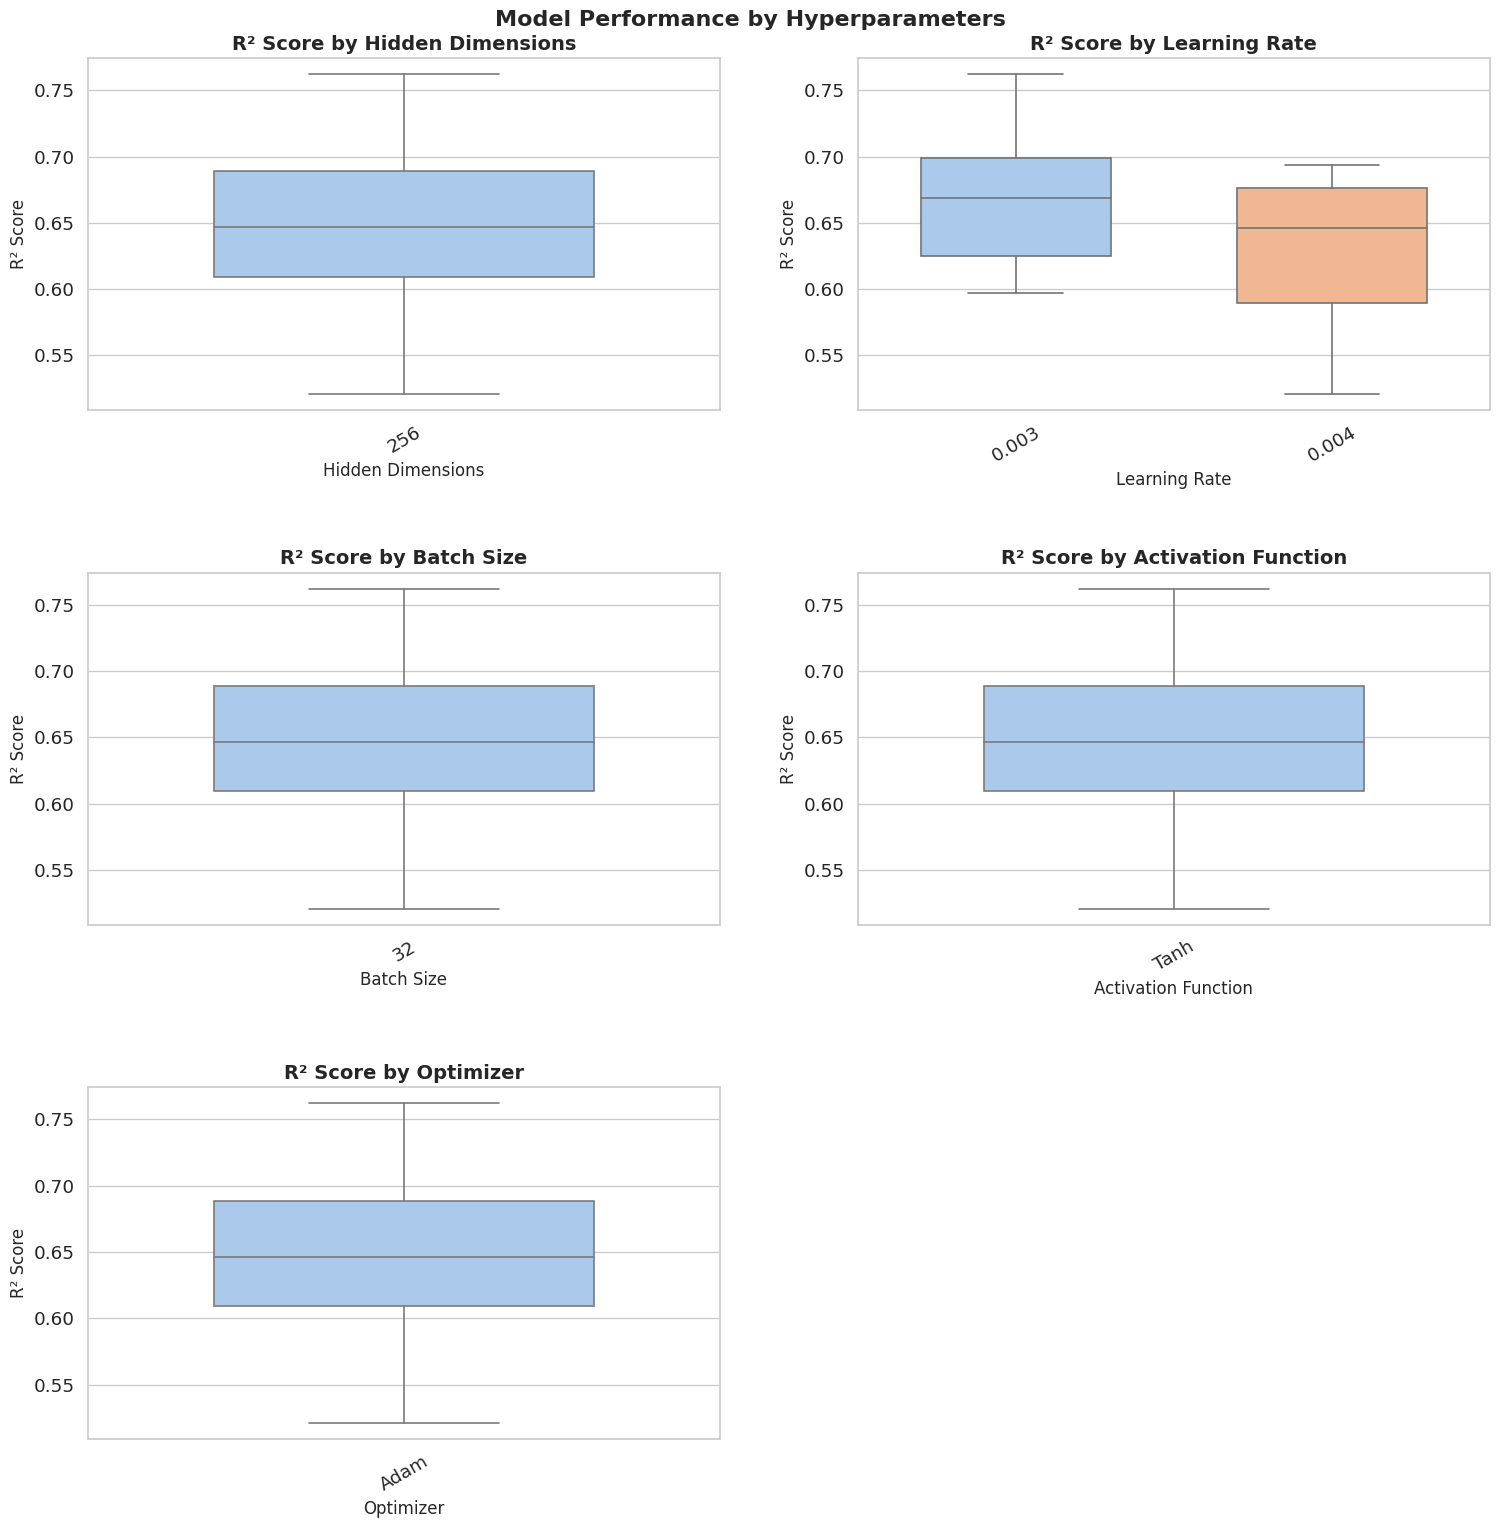


Best Configuration:
Run ID        : mlp_256h_3e-03lr_32bs_10000ep_Tanh_Adam
Hidden Dim    : 256
Learning Rate : 0.00300
Batch Size    : 32
Activation Fn : Tanh
Optimizer     : Adam
R² Score      : 0.7622
MAE           : 0.0283
MSE           : 0.001648


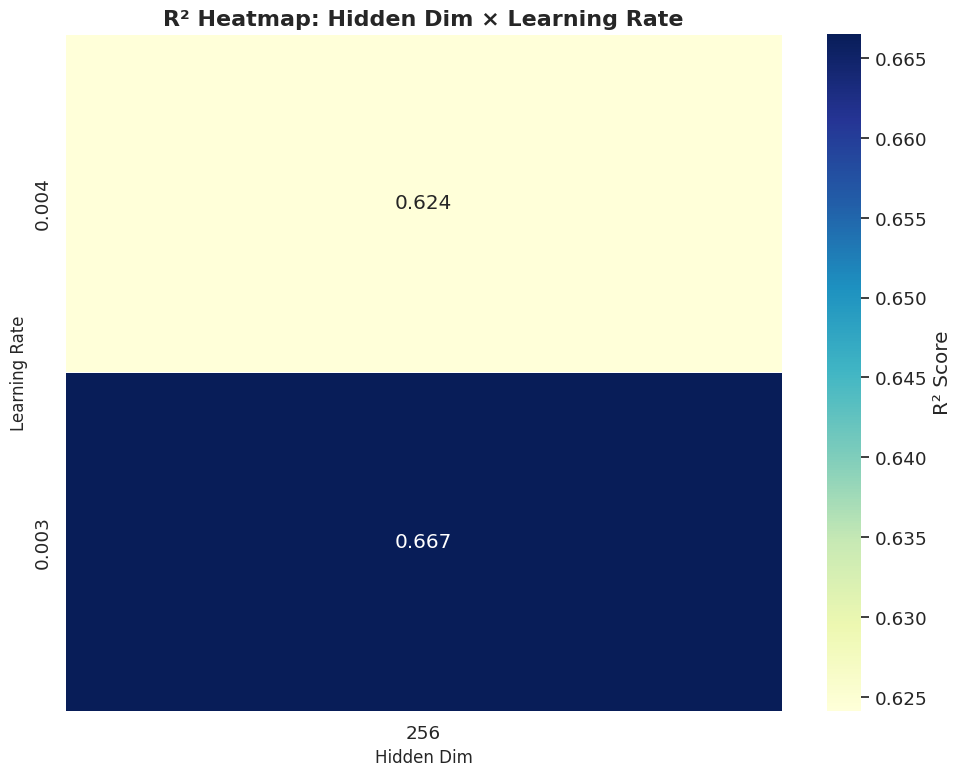


 R² threshold (95% of max): 0.7241
🔍 Found 2 stable candidates:

    hidden_dim     lr  batch_size activation_fn optimizer_name      R2  \
24         256  0.003          32          Tanh           Adam  0.7622   
12         256  0.003          32          Tanh           Adam  0.7272   

       MAE       MSE  
24  0.0283  0.001648  
12  0.0316  0.001891  


In [8]:
# 📁 src/tuning/visualize_search_results.py
# ➞ Heatmap visualization of R² scores across hidden_dim and learning rate combinations

# 📅 Load experiments log
log_path = "experiments/experiments_log.csv"
df_log = pd.read_csv(LOG_CSV_PATH)

# Современный стиль
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)

# Создаём 3×2 подграфика
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
axes = axes.flatten()

# Список параметров и названий
plot_params = [
    ("hidden_dim", "Hidden Dimensions"),
    ("lr", "Learning Rate"),
    ("batch_size", "Batch Size"),
    ("activation_fn", "Activation Function"),
    ("optimizer_name", "Optimizer")
]

# Строим графики
for i, (param, label) in enumerate(plot_params):
    ax = axes[i]
    sns.boxplot(x=param, y="R2", data=df_log, ax=ax, width=0.6, fliersize=2, linewidth=1.2)
    ax.set_title(f"R² Score by {label}", fontsize=14, fontweight='bold')
    ax.set_xlabel(label, fontsize=12)
    ax.set_ylabel("R² Score", fontsize=12)
    ax.xaxis.set_tick_params(rotation=30)

# Удаляем последний пустой subplot, если графиков меньше
if len(axes) > len(plot_params):
    fig.delaxes(axes[-1])

plt.tight_layout(pad=3)
plt.subplots_adjust(top=0.95)
fig.suptitle("Model Performance by Hyperparameters", fontsize=16, fontweight='bold')

plt.show()

# Выводим лучшую конфигурацию
best_row = df_log.loc[df_log["R2"].idxmax()]
print("\nBest Configuration:")
print(f"Run ID        : {best_row['run_id']}")
print(f"Hidden Dim    : {int(best_row['hidden_dim'])}")
print(f"Learning Rate : {best_row['lr']:.5f}")
print(f"Batch Size    : {int(best_row['batch_size'])}")
print(f"Activation Fn : {best_row['activation_fn']}")
print(f"Optimizer     : {best_row['optimizer_name']}")
print(f"R² Score      : {best_row['R2']:.4f}")
print(f"MAE           : {best_row['MAE']:.4f}")
print(f"MSE           : {best_row['MSE']:.6f}")

# ------------------------------
# 🔥 Heatmap of R² by hidden_dim × learning rate
# ------------------------------

# Группируем по hidden_dim и lr, берём среднее R²
pivot_table = df_log.pivot_table(
    values="R2",
    index="lr",         # строки — learning rate
    columns="hidden_dim",  # колонки — hidden_dim
    aggfunc="mean"
)

# Сортируем для лучшей читаемости
pivot_table = pivot_table.sort_index(ascending=False)

# Отрисовка
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu", linewidths=0.5, cbar_kws={"label": "R² Score"})
plt.title("R² Heatmap: Hidden Dim × Learning Rate", fontsize=16, fontweight='bold')
plt.xlabel("Hidden Dim", fontsize=12)
plt.ylabel("Learning Rate", fontsize=12)
plt.tight_layout()
plt.show()

# ------------------------------
# 📊 Зона стабильных параметров по R²
# ------------------------------

# 1. Максимальное значение R²
r2_max = df_log["R2"].max()

# 2. Порог: 95% от максимума
threshold = r2_max * 0.95
print(f"\n R² threshold (95% of max): {threshold:.4f}")

# 3. Отбираем устойчиво хорошие параметры
stable_zone = df_log[df_log["R2"] >= threshold]
print(f"🔍 Found {len(stable_zone)} stable candidates:\n")

# 4. Выводим таблицу устойчивых параметров
print(stable_zone.sort_values("R2", ascending=False)[["hidden_dim", "lr", "batch_size", "activation_fn", "optimizer_name", "R2", "MAE", "MSE"]])
